<a id='sect0'></a>
## <font color='darkblue'>Preface</font>
From [**Issue4**](https://github.com/johnklee/ff_crawler/issues/4), we are going to work on the model to extract NER from article/post of Reddit based on inital labelled document [here](https://docs.google.com/document/d/1ACU5iDe6QkLZuMzyzaR0e_TUtw8Bht_IvQpO6_AZuCI/edit?usp=sharing&resourcekey=0-7WPgbTf3MfSIWZnIugZjxg):
* <font color='orange'>**Pixel phone model**</font>: T1
* <font color='green'>**Remote model**</font>: T2
* <font color='LightCoral'>**Symptom**</font>: T3
* <font color='Indigo'>**Recover way**</font>: T4
* <font color='LightSkyBlue'>**Build**</font>: T5
* <font color='Khaki'>**Reference phone**</font>: T6

In [1]:
import os
import json
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 1
TEST_SIZE = 0.2

# https://www.w3schools.com/colors/colors_names.asp
# https://gist.github.com/jonsuh/3c89c004888dfc7352be
class color:
   LIGHTCORAL='\033[38;2;240;128;128m'
   LIGHTSKYBLUE='\033[38;2;135;206;250m'
   KHAKI='\033[38;2;240;230;140m'
   INDIGO='\033[38;2;72;0;130m'
   ORANGE='\033[38;2;255;165;0m'
   LIGHTRED='\033[1;31m'
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'>[**Data Set**](#sect1)</font>
* <font size='3ptx'>[**Reddit APIs**](#sect2)</font>
  * [PRAW APIs to pull posts](#sect2_1)
* <font size='3ptx'>[**Word2vec Solution**](#sect3)</font>
* <font size='3ptx'>[**ML Models**](#sect4)</font>

## <font color='darkblue'>Data Set</font> ([back](#sect0))
We collect and label our data from dumped data [here](https://drive.google.com/file/d/1LTyPKtafRQnQp-DslpjBM5QUWoxAtSTY/view?usp=sharing). Let's load labelling data back for future process:

In [2]:
df = pd.read_csv("issue4_data.csv")
df.head(n=100)

,source,sentence
0,https://www.reddit.com/r/GooglePixel/comments/kspwba/bluetooth_is_terrible/,My P4a5g\_T1 keeps having bluetooth problems .
1,https://www.reddit.com/r/GooglePixel/comments/kspwba/bluetooth_is_terrible/,I have the sony\_T2 wh-1000mx4\_T2 and they just keep\_T3 disconnecting\_T3 .
2,https://www.reddit.com/r/GooglePixel/comments/kspwba/bluetooth_is_terrible/,But once I pause\_T3 the\_T3 media\_T3 it\_T3 disconnects\_T3 and I have to restart\_T4 the\_T4 bluetooth\_T4 on\_T4 my\_T4 phone\_T4 to\_T4 get\_T4 it\_T4 to\_T4 reconnect\_T4 .
3,https://www.reddit.com/r/GooglePixel/comments/kspwba/bluetooth_is_terrible/,Does anyone else having this problem or are my settings wrong somewhere .
4,https://www.reddit.com/r/GooglePixel/comments/lgofla/pixel_4a_5g_bluetooth_issues/,Pixel\_T1 4a\_T1 5g\_T1 Bluetooth issues
5,https://www.reddit.com/r/GooglePixel/comments/lgofla/pixel_4a_5g_bluetooth_issues/,I have been having issues\_T3 with\_T3 Bluetooth\_T3 connectivity\_T3 with the new pixel\_T1 4a\_T1 5g\_T1 .
6,https://www.reddit.com/r/GooglePixel/comments/lgofla/pixel_4a_5g_bluetooth_issues/,1st it started with my Fitbit\_T2 where the\_T3 app\_T3 would\_T3 occasionally\_T3 not\_T3 find\_T3 the\_T3 device\_T3 and I would need to forget\_T4 and\_T4 add\_T4 the\_T4 Fitbit\_T4 again\_T4 .
7,https://www.reddit.com/r/GooglePixel/comments/lgofla/pixel_4a_5g_bluetooth_issues/,More recently it has issues where the Bluetooth\_T3 connection\_T3 to\_T3 car\_T3 audio\_T3 or\_T3 wireless\_T3 earphones\_T3 keeps\_T3 dropping\_T3 whenever\_T3 I\_T3 switch\_T3 between\_T3 apps\_T3 like\_T3 spotify\_T3 and\_T3 Google\_T3 maps\_T3 or\_T3 podcasts\_T3 and\_T3 Strava\_T3 .
8,https://www.reddit.com/r/GooglePixel/comments/kdf2tc/pixel_4a_5g_constantly_dropping_bluetooth/,Pixel\_T1 4a\_T1 5g\_T1 constantly\_T3 dropping\_T3 bluetooth\_T3
9,https://www.reddit.com/r/GooglePixel/comments/kdf2tc/pixel_4a_5g_constantly_dropping_bluetooth/,Both my Bose\_T2 QC\_T2 35\_T2 headphones and a bluetooth\_T2 speaker\_T2 disconnect\_T3 and\_T3 reconnect\_T3 when\_T3 no\_T3 audio\_T3 is\_T3 playing\_T3 .


In [3]:
word_set = set()
label_t1 = label_t2 = label_t3 = label_t4 = label_t5 = label_t6 = label_o = 0
for ri, r in df.iterrows():
    words = r.sentence.split()
    for i in range(len(words)):                
        # if words[i][-1] in ",.!?":
        #    words[i] = words[i][:-1]
        #elif words[i][-2:] == "'s":
        #    words[i] = words[i][:-2]
            
        if words[i].startswith('('):
            words[i] = words[i][1:]
            
        if words[i].endswith(')'):
            words[i] = words[i][:-1]
            
    new_words = []
    for w in words:
        if w.endswith('\_T1'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.ORANGE}{w}{color.END}"
            label_t1 += 1
            
        elif w.endswith('\_T2'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.GREEN}{w}{color.END}"
            label_t2 += 1
            
        elif w.endswith('\_T3'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.LIGHTCORAL}{w}{color.END}"
            label_t3 += 1
            
        elif w.endswith('\_T4'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.INDIGO}{w}{color.END}"
            label_t4 += 1
            
        elif w.endswith('\_T5'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.LIGHTSKYBLUE}{w}{color.END}"
            label_t5 += 1
            
        elif w.endswith('\_T6'):
            w = w[:-4]
            word_set.add(w)
            w = f"{color.BOLD}{color.KHAKI}{w}{color.END}"
            label_t6 += 1
            
        else:
            label_o += 1
            
        new_words.append(w)
        
    print(" ".join(new_words))

My P4a5g keeps having bluetooth problems .
I have the sony wh-1000mx4 and they just keep disconnecting .
But once I pause the media it disconnects and I have to restart the bluetooth on my phone to get it to reconnect .
Does anyone else having this problem or are my settings wrong somewhere .
Pixel 4a 5g Bluetooth issues
I have been having issues with Bluetooth connectivity with the new pixel 4a 5g .
1st it started with my Fitbit where the app would occasionally not find the device and I would need to forget and add the Fitbit again .
More recently it has issues where the Bluetooth connection to car audio or wireless earphones keeps dropping whenever I switch between apps like spotify and Google maps or podcasts and Strava .
Pixel 4a 5g constantly dropping bluetooth
Both my Bose QC 35 headphones and a bluetooth speaker disconnect and reconnect when no audio is playing .
This did not happen on my Pixel 3a , Nexus 6P or Galaxy S7 .
Song information over Bluetooth with Pixel 5 ?
Has anyon

In [4]:
for n, v in sorted(
        [(n, v) for n, v in globals().items() if n.startswith('label_t') or n.startswith('label_o')],
        key=lambda t: t[0]):
    print(f"{n}: {v}")

label_o: 280
label_t1: 24
label_t2: 19
label_t3: 164
label_t4: 17
label_t5: 6
label_t6: 9


We store a list of car brands for future reference and process in file `car_brand_list.txt`.

In [5]:
phone_brand_set = set()
with open('phone_brands.txt', 'r') as fo:
    for line in fo:
        line = line.lower()
        phone_brand_set.add(tuple(list(map(lambda w: w.lower(), line.split()))))
    
list(phone_brand_set)[:10]

[('pixel',), ('galaxy',), ('apple',), ('nexus',)]

In [6]:
device_brand_set = set()
with open('remote_device_brands.txt', 'r') as fo:
    for line in fo:
        line = line.lower()
        device_brand_set.add(tuple(list(map(lambda w: w.lower(), line.split()))))
    
list(device_brand_set)[:10]

[('fitbit',)]

We also keep many post to hold content without desired entity which can be used for training in directory `negative_posts`:

In [7]:
NEGATIVE_DIR_PATH = 'negative_posts'

## <font color='darkblue'>Reddit APIs</font>
Here we are going to pull posts/articles from [**Reddits**](https://www.reddit.com/) by APIs of [**PRAW**](https://praw.readthedocs.io/en/latest/) to help us collect more posts/articles for labelling process:
1. Pull posts from Reddit by open API
2. Train a classifier to select the post we are interested (contains the labels we want)

In [8]:
#!pip install praw

<a id='sect2_1'></a>
### <font color='darkgreen'>PRAW APIs to pull posts</font>
First step, we are going to pull posts from Reddit and then do manual labelling to separate the wanted posts and others:
* Follow [this post](https://www.jcchouinard.com/get-reddit-api-credentials-with-praw/) to retrieve the client id, secret which will be provided into API later. (We store the credentials in `client_secrets.json` here. If this is your first time to use this script, try to create a reddit app [here](https://www.reddit.com/prefs/apps/))

In [9]:
import logging
import praw
import json

with open('client_secrets.json', 'r') as fo:
    reddit_credentials = json.load(fo)
    rdt_agent = praw.Reddit(**reddit_credentials)


# Make sure you can see your name to indicate that you are ready to use APIs
rdt_agent.user.me()

Redditor(name='johnkclee')

* Now our PRAW APIs are ready to use. Let's pull a few post for our reference as prior run:
  * [**Reddit** (rdt_agent)](https://praw.readthedocs.io/en/latest/code_overview/reddit_instance.html?highlight=Reddit#the-reddit-instance): The Reddit class provides convenient access to Reddit’s API.
  * [**Subreddit** (st_googlepixel)](https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html?highlight=Subreddit#subreddit): A class for Subreddits.
  * [**Submission** (submission)](https://praw.readthedocs.io/en/latest/code_overview/models/submission.html#praw.models.Submission): A class for submissions to reddit.

In [10]:
# Create a sub-reddit object for topic we are interested in (r/GooglePixel)
st_googlepixel = rdt_agent.subreddit("GooglePixel")

print(st_googlepixel.display_name)
# Output: redditdev
#print(st_googlepixel.title)
# Output: reddit development
#print(st_googlepixel.description)
# Output: a subreddit for discussion of ...

GooglePixel


In [11]:
# Obtain Submission Instances from a sub-reddit
for submission in st_googlepixel.new(limit=3):
    print(color.BOLD + submission.title + color.END)
    # Output: the submission's title
    print(submission.score)
    # Output: the submission's score
    print(submission.id)
    # Output: the submission's ID
    print(submission.url)
    # Output: the URL the submission points to or the submission's URL if it's a self post
    print("\n" + submission.selftext + "\n\n")
    # Output: The body of submission

People who hear the electrical hum/buzz/static in the right Pixel Bud 2: Anyone exchanged and found a pair that didn't have that humming?
1
n82rbs
https://www.reddit.com/r/GooglePixel/comments/n82rbs/people_who_hear_the_electrical_humbuzzstatic_in/

While playing something, turn the volume down and I can hear the electrical hum in the right earbud. I had the buds for a couple of days before I noticed it, and now I can't un-hear it. I exchanged for a second pair, and the second pair has electrical hum, too.

For people who know that noise and also tried exchanging: Did you find a pair that doesn't have the noise? I really like everything about the Pixel Buds, but I have to admit that humming is a deal breaker for me. If people had luck with eventually finding a good pair, I might try my luck with a third pair; otherwise I'll probably just return it before the refund period is up. :/ 

Thanks!


Should I buy Pixel 4XL or 5?
1
n82jj2
https://www.reddit.com/r/GooglePixel/comments/n82jj2/sh

* If you can see pulled posts from above code snippet, then it is ready to pull volume of posts now (Set `enable_demo=True`):

In [70]:
import pickle
import os
import time
from logb import get_logger
from datetime import datetime
from typing import Dict
from tqdm import tqdm

ROOT_PATH = os.getcwd()
CACHE_PKL_NAME = os.path.join(ROOT_PATH, 'reddit_pulled_post_cache.pkl')
DUMP_DIR_PATH = os.path.join(ROOT_PATH, "reddit_post_dumps")
PULL_SIZE_LIMIT = 1000
logger = get_logger("issue4")
enable_demo = False


def get_ts() -> int:
    return int(datetime.now().timestamp())

def get_datestr() -> str:
    return datetime.now().strftime("%Y%m%d%H%M%S")

def dump_reddit_post(datestr, submission):
    url = submission.url.split('?')[0]
    if url.endswith('/'):
        url = url[:-1]
        
    def _save(fn):
        with open(os.path.join(DUMP_DIR_PATH, fn), 'w', encoding='utf-8') as fw:
            fw.write(submission.url + "\n\n")
            fw.write(submission.title + "\n\n")
            fw.write(submission.selftext)
            
    try:
        id_with_title = '_'.join(url.split('/')[-2:])
        fn = f"{datestr}_{id_with_title}.txt"
        _save(fn)
    except Exception:
        logger.warning(f"Fail to use fn={fn} with URL={url}")
        fn = f"{datestr}_{submission.id}.txt"
        logger.warning(f"Using fn={fn} instead...")
        _save(fn)

def load_rpp_cache() -> Dict[str, float]:
    """ Load Reddit pulled post cache"""
    cache_dict = {} # Key as URL, value as pulling stamp    
    if os.path.isfile(CACHE_PKL_NAME):
        try:
            with open(CACHE_PKL_NAME, 'rb') as fo:
                cache_dict = pickle.load(fo)
        except:
            logger.warning(f"Fail to load back {CACHE_PKL_NAME}!")            
            os.remove(CACHE_PKL_NAME)
            return {}
    
    return cache_dict
        
def save_rpp_cache(cache_dict:Dict[str,float]):
    """ Save Reddit pulled post cache"""
    with open(CACHE_PKL_NAME, 'wb') as fw:
        pickle.dump(cache_dict, fw)
        

if enable_demo:
    ### Start the Reddit dump process
    rppc_cache = load_rpp_cache()

    if not os.path.isdir(DUMP_DIR_PATH):
        os.makedirs(DUMP_DIR_PATH)
    
    st = datetime.now()
    datestr = get_datestr()
    print(f"Start Reddit dumping at {datestr}...")
    time.sleep(1)
    # Obtain Submission Instances from a sub-reddit
    new_post_count = 0
    with tqdm(total=PULL_SIZE_LIMIT) as pbar:
        pc = 0
        for submission in st_googlepixel.new(limit=PULL_SIZE_LIMIT):
            if submission.url not in rppc_cache:
                rppc_cache[submission.url] = get_ts()
                dump_reddit_post(datestr, submission)
                new_post_count += 1
            
            pbar.update(1)
            pc += 1
        
        pbar.update(PULL_SIZE_LIMIT - pc)
    
    logger.info(f"Total {new_post_count:,d} new post collected! ({datetime.now() - st})")
    save_rpp_cache(rppc_cache)

Above code has been refactored and we will use script `reddit_dumper.py` to dump posts of Reddit instead in server.

<a id='sect3'></a>
## <font color='darkblue'>Word2vec Solution</font> ([back](#sect0))
* [**Fasttext**](#sect2_1)
* [**Gensim**](#sect2_2)

[**Word2vec**](https://en.wikipedia.org/wiki/Word2vec) is a technique for [natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing). The word2vec algorithm uses a neural network model to learn word associations from a large [corpus of text](https://en.wikipedia.org/wiki/Corpus_of_text). Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence.
![1.png](images/1.png)
<br/>

<a id='sect2_1'></a>
### <font color='darkgreen'>Fasttext - Word to vector</font>
Here we will leverage [**Fasttext**](https://github.com/facebookresearch/fastText) package to help us to translate word into vector for later ML training. Instead of re-training a new Fasttext model, we will use exist trained model [here](https://fasttext.cc/docs/en/crawl-vectors.html) [cc.en.300.bin.gz](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz). Please click the link and download it:

In [13]:
#!pip install fasttext

In [14]:
#import fasttext.util

#fasttext.util.download_model('en', if_exists='ignore')  # English
#ft = fasttext.load_model('cc.en.300.bin')

After that, below code will load the downloaded model:

In [15]:
#import fasttext
#import fasttext.util

<a id='sect2_2'></a>
### <font color='darkgreen'>Gensim - Word to vector</font>
Here we will leverage [**Gensim**](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) to help us to translate word into vector for later ML training.

In [16]:
# Load in word vector translator
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [17]:
unknown_word_set = set()
for w in word_set:
    try:
        wv[w]
    except:
        unknown_word_set.add(w)
        
print(f"Total {len(unknown_word_set)} unknown word(s) found!")
print(unknown_word_set)

Total 12 unknown word(s) found!
{'W10', 'spotify', '6-digit', 'and', 'a', 'wh-1000mx4', 'P4a5g', '11', '35', 'smartwatch', 'to', '10'}


<a id='sect4'></a>
## <font color='darkblue'>ML Models</font>
Here we are going to explore some ML solutions to deal with NER problem.

In [18]:
#!pip uninstall sklearn
#!pip install scikit-learn==0.23.0

### <font color='darkgreen'>Post classifier</font>
We need a classifier to help us select post of Reddit from the dump collection to save our time to check all post. We put the interested posts under folder `pos` and others in folder `neg`. Below we will train a classifier to help us identify the post as those posts in folder `pos` (with label as `1`).

#### Preprocess

In [19]:
import nltk
import pickle
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from sklearn.ensemble import StackingClassifier
from deslib.des.knora_e import KNORAE
from deslib.des.knora_u import KNORAU
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

wnl = WordNetLemmatizer()

def read_post_from_file(fn):
    ''' Read Reddit post from file'''
    title = body = url = ''
    with open(fn, 'r', encoding='utf-8') as fo:
        url = fo.readline().strip()
        fo.readline()
        title = fo.readline().strip()
        fo.readline()
        body = fo.read().strip()

    return (title, body, url)

print(sklearn.show_versions())

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(



System:
    python: 3.8.7 (tags/v3.8.7:6503f05, Dec 21 2020, 17:59:51) [MSC v.1928 64 bit (AMD64)]
executable: c:\users\john\appdata\local\programs\python\python38\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
       pip: 21.1.1
setuptools: 49.2.1
   sklearn: 0.23.0
     numpy: 1.20.2
     scipy: 1.5.2
    Cython: 0.29.21
    pandas: 1.1.5
matplotlib: 3.3.2
    joblib: 1.0.0

Built with OpenMP: True
None


In [119]:
%%time
VSET_SERIALIZED_FILENAME = 'reddit_vset.pkl'
MIN_V_SIZE = 3
BT_KW_SET = {'bt', 'bluetooth'}
vset = set()
post_list = []

for label, td in [(1, 'reddit_post_dumps/pos'), (0, 'reddit_post_dumps/neg')]:
    for f in os.listdir(td):
        fp = os.path.join(td, f)
        post_list.append((label, fp))
        title, body, url = read_post_from_file(fp)
        text = title + '\n' + body
        for sent in sent_tokenize(text):
            words = word_tokenize(sent)
            wt_pairs = pos_tag(words)
            for w, t in wt_pairs:
                w = wnl.lemmatize(w)
                if len(w) > MIN_V_SIZE and t.startswith('V'):
                    vset.add(w.lower())

Wall time: 3.7 s


In [120]:
with open(VSET_SERIALIZED_FILENAME, 'wb') as fw:
    pickle.dump(vset, fw)
    
len(vset)

1368

In [22]:
def file2vec(fp):
    '''
    Feature vector = [title_wv_300, body_wv_300, ohe_of_vset, num_of_bt, title_wset_size, body_wset_size]
    '''
    feats = []
    title_wset = set()
    body_wset = set()
    title_vec = np.zeros(300)
    body_vec = np.zeros(300)
    bt_count = 0
    title, body, url = read_post_from_file(fp)
    for sent in nltk.sent_tokenize(body):
            for w in nltk.tokenize.word_tokenize(sent):
                w = w.lower()
                if w in BT_KW_SET:
                    bt_count += 1
                try:
                    body_vec += wv[w]
                    body_wset.add(wnl.lemmatize(w))                    
                except:
                    pass
                
    for w in nltk.tokenize.word_tokenize(title):
        w = w.lower()
        if w in BT_KW_SET:
            bt_count += 1
        try:
            title_vec += wv[w]
            title_wset.add(wnl.lemmatize(w))
        except:
            pass
        
    feats.extend(title_vec.copy())
    feats.extend(body_vec.copy())    
    for v in vset:
        if v in body_wset or v in title_wset:
            feats.append(1)            
        else:
            feats.append(0)
            
    feats.append(bt_count)
    feats.append(len(title_wset))
    feats.append(len(body_wset))
    return feats

In [121]:
# Check vector size
print(f"Fector of {post_list[0][1]}")
len(file2vec(post_list[0][1]))

Fector of reddit_post_dumps/pos\20210507070501_mt45yy_bluetooth_issues_since_april_update.txt


1971

In [24]:
# Build training/testing dataset X, y
# Feature vector = [title_wv_300, body_wv_300, ohe_of_vset, num_of_bt]
import pandas as pd

def get_dataset():
    df_columns = []
    df_columns.extend([f"title_wv_{i}" for i in range(300)])
    df_columns.extend([f"body_wv_{i}" for i in range(300)])
    df_columns.extend([f"vest_ohe_{i}" for i in range(len(vset))])
    df_columns.append('num_of_bt')
    df_columns.append('title_wset_size')
    df_columns.append('body_wset_size')
    df_columns.append('target')
    df_columns.append('source')
    rows = []
    for label, fp in post_list:
        feat = file2vec(fp)
        feat.append(label)
        feat.append(fp)
        rows.append(feat)
        
    
    df = pd.DataFrame(
        data=rows, 
        columns=df_columns
    )

    X = df.drop(['target', 'source'], axis=1)
    y = df['target']
    return X, y, df

In [122]:
# Get training/testing data
X, y, df = get_dataset()

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X.sample(n=5)

,title_wv_0,title_wv_1,title_wv_2,title_wv_3,title_wv_4,title_wv_5,title_wv_6,title_wv_7,title_wv_8,title_wv_9,...,vest_ohe_1361,vest_ohe_1362,vest_ohe_1363,vest_ohe_1364,vest_ohe_1365,vest_ohe_1366,vest_ohe_1367,num_of_bt,title_wset_size,body_wset_size
344,1.087952,-0.115723,0.614136,0.621338,-1.266479,0.059814,-0.439819,-0.510010,0.547974,-0.043335,...,0,0,0,0,0,0,0,0,8,3
201,0.541138,0.799805,1.193237,-0.055932,-0.631958,0.962654,1.235046,-0.957764,0.746094,0.386719,...,0,0,0,0,0,0,0,0,9,193
62,0.035645,-0.184814,-0.391602,0.644531,-0.334961,-0.058655,0.251465,0.010742,0.098145,0.187988,...,0,0,0,0,0,0,0,2,2,6
148,-0.036133,0.257394,0.069336,0.363281,-0.199829,-0.033325,-0.159668,-0.314453,0.199707,0.532104,...,0,0,0,0,0,0,0,0,4,83
296,0.582458,-0.446411,0.286743,1.735352,-0.854523,0.515442,0.610229,-0.889648,-0.005981,0.344727,...,0,0,0,0,0,0,0,0,12,19


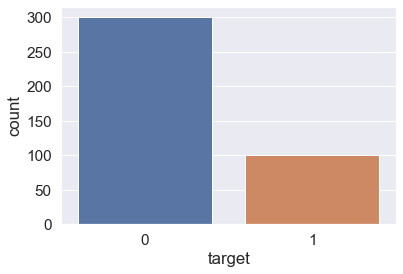

In [123]:
# Check if there is a scenario of imbalance dataset
# More: https://github.com/johnklee/ml_articles/tree/master/others/imbalance_data_by_smote
ax = sns.countplot(x='target', data=df)

In [28]:
# === Now, let's train the classifiers and pickup the best one ===

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression(solver='liblinear')))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC(C=10)))
    level0.append(('bayes', GaussianNB()))

    # define meta learner model
    level1 = LogisticRegression()

    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [29]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression(solver='liblinear')
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC(C=10)
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models

In [30]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [124]:
%%time
# define dataset
X, y, _ = get_dataset()

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.957 (0.030)
>knn 0.791 (0.063)
>cart 0.954 (0.033)
>svm 0.802 (0.029)
>bayes 0.787 (0.043)
>stacking 0.966 (0.028)
Wall time: 35.1 s


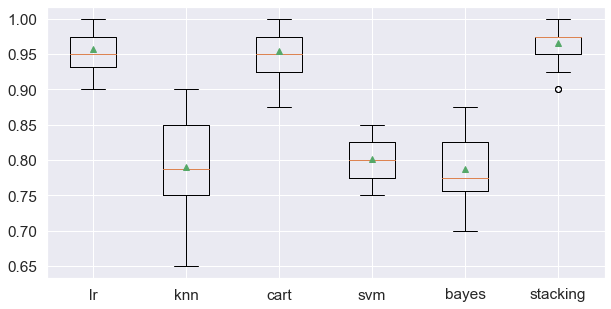

In [125]:
# plot model performance for comparison
plt.rcParams['figure.figsize'] = [10, 5]
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

From above, [**stacking**](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking) ([more](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)) perform the best. Let's check the confusion matrix of it:

In [126]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

model = get_stacking()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
X_test.sample(n=10)

,title_wv_0,title_wv_1,title_wv_2,title_wv_3,title_wv_4,title_wv_5,title_wv_6,title_wv_7,title_wv_8,title_wv_9,...,vest_ohe_1361,vest_ohe_1362,vest_ohe_1363,vest_ohe_1364,vest_ohe_1365,vest_ohe_1366,vest_ohe_1367,num_of_bt,title_wset_size,body_wset_size
296,0.582458,-0.446411,0.286743,1.735352,-0.854523,0.515442,0.610229,-0.889648,-0.005981,0.344727,...,0,0,0,0,0,0,0,0,12,19
122,0.187500,-0.888611,-0.998535,-0.188782,-0.811768,0.791504,0.259888,0.289551,1.040283,-0.109985,...,0,0,0,0,0,0,0,1,5,92
92,0.295654,-0.485352,0.005859,0.906738,-0.811157,0.044197,0.404907,-0.432037,0.332275,0.068604,...,0,0,0,0,0,0,0,9,7,140
339,0.193848,0.037109,0.326904,0.757874,-1.047119,0.156281,0.595703,-1.132568,0.402100,-0.161133,...,0,1,0,0,0,0,1,1,8,1159
321,0.195801,0.205078,-0.174072,-0.096436,0.049072,0.262695,-0.023926,0.162109,0.068848,0.293945,...,0,0,0,0,0,0,0,0,2,50
132,-0.307129,0.176758,-0.109985,0.004395,-0.104980,0.378418,0.423309,-0.244141,0.467773,0.478699,...,0,0,0,0,0,0,0,0,2,27
385,0.616852,0.586792,0.996979,0.619629,-1.564575,0.646240,0.220367,-0.198120,0.604858,0.679901,...,0,0,0,0,0,0,0,0,10,26
117,0.317871,-0.046997,0.005615,0.658203,-0.738281,-0.198730,0.502533,-0.994873,0.541016,0.442993,...,0,0,0,0,0,0,0,0,6,42
354,-0.075195,-0.091309,0.527222,-0.184158,0.011169,-0.361694,0.421875,0.078186,0.314941,0.835938,...,0,0,0,0,0,0,0,0,7,18
242,0.246582,-0.062012,-0.125732,0.831543,-0.889038,-0.559326,0.956665,-0.448975,0.733398,0.340942,...,0,0,0,0,0,0,0,0,7,13


In [127]:
for i, (ans, pred, prob) in enumerate(zip(y_test.tolist(), y_pred.tolist(), y_pred_prob.tolist())):
    if ans != pred:
        print(f"Ans={ans}; Predict={pred}; Prob={prob[0]:.02f}, {prob[1]:.02f} ({df.iloc[X_test.index[i]].source})")

Ans=0; Predict=1; Prob=0.25, 0.75 (reddit_post_dumps/neg\20210507070501_mzpzgv_controlling_spotify_mobile_via_desktop_app.txt)
Ans=1; Predict=0; Prob=0.55, 0.45 (reddit_post_dumps/pos\cc_34.txt)
Ans=1; Predict=0; Prob=0.54, 0.46 (reddit_post_dumps/pos\cc_2.txt)


In [114]:
def draw_cm(y_test, y_pred):
    ''' Draw Confusion Matrix'''
    # https://www.kaggle.com/agungor2/various-confusion-matrix-plots
    data = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (8,6))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

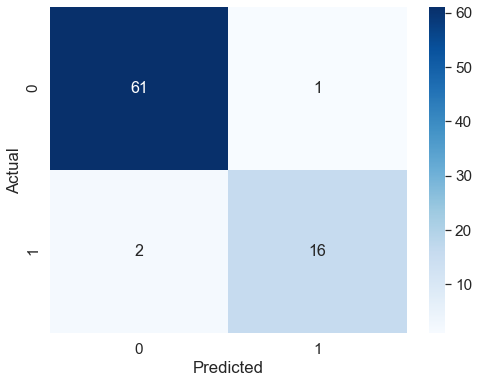

In [128]:
draw_cm(y_test, y_pred)

The confusion matrix of model [LGTM](https://www.dictionary.com/e/acronyms/lgtm/)! Let's seralized the model for future usage:

In [129]:
import pickle

# Retrain the model with full dataset
model = get_stacking()
model.fit(X, y)

POST_CLASSIFIER_PKL_NAME = 'reddit_post_classifier.pkl'
with open(POST_CLASSIFIER_PKL_NAME, 'wb') as fw:
    pickle.dump(model, fw)

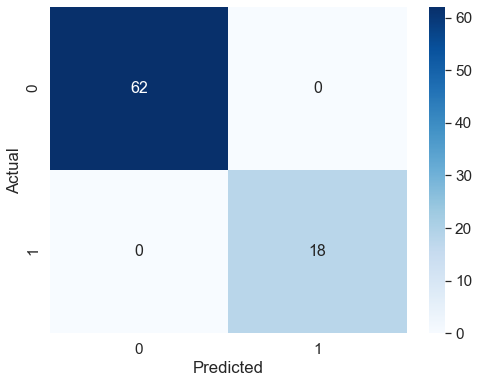

In [130]:
# Load the serialized model back for evaluation
with open(POST_CLASSIFIER_PKL_NAME, 'rb') as fo:
    model = pickle.load(fo)
    
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
draw_cm(y_test, y_pred)

In [118]:
for i, (ans, pred, prob) in enumerate(zip(y_test.tolist(), y_pred.tolist(), y_pred_prob.tolist())):
    if ans != pred:
        print(f"Ans={ans}; Predict={pred}; Prob={prob[0]:.02f}, {prob[1]:.02f} ({df.iloc[X_test.index[i]].source})")

### <font color='darkgreen'>CRF </font>
Pleae refer to this [notebook](https://nbviewer.jupyter.org/github/johnklee/ml_articles/blob/master/medium/NLP_Guide_Identifying_Part_of_Speech_Tags_using_Conditional_Random_Fields/notebook.ipynb) for more details.

In [40]:
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn_crfsuite import CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold,StratifiedKFold
from collections import Counter
import nltk
#nltk.download("punkt")

In [41]:
def is_car_brand(sentence, index):
    for car_brand in car_brand_set:
        if ' '.join(car_brand) == ' '.join(list(map(lambda w: w.lower(), sentence[index:index+len(car_brand)]))):
            return 1
        
    return 0

def crf_features(sentence, index):
    ### sentence is of the form [w1,w2,w3,..], index is the position of the word in the sentence
    return {
        'is_car_brand': is_car_brand(sentence, index),
        'is_first_capital':int(sentence[index][0].isupper()),
        'is_first_word': int(index==0),
        'is_last_word':int(index==len(sentence)-1),
        'is_complete_capital': int(sentence[index].upper()==sentence[index]),
        'prev_word':'' if index==0 else sentence[index-1],
        'prev_2word':'' if index<=1 else ''.join(sentence[index-2:index]),
        'prev_3word':'' if index<=2 else ''.join(sentence[index-3:index]),
        'next_word':'' if index<=len(sentence)-1 else sentence[index+1],
        'next_2word':'' if index<=len(sentence)-2 else sentence[index+1:index+2],
        'next_3word':'' if index<=len(sentence)-3 else sentence[index+1:index+3],
        'is_numeric':int(sentence[index].isdigit()),
        'is_alphanumeric': int(bool((re.match('^(?=.*[0-9]$)(?=.*[a-zA-Z])',sentence[index])))),
        'prefix_1':sentence[index][0],
        'prefix_2': sentence[index][:2],
        'prefix_3':sentence[index][:3],
        'prefix_4':sentence[index][:4],
        'suffix_1':sentence[index][-1],
        'suffix_2':sentence[index][-2:],
        'suffix_3':sentence[index][-3:],
        'suffix_4':sentence[index][-4:],
        'word_has_hyphen': 1 if '-' in sentence[index] else 0  
    }

In [42]:
# See how a sentence is translated into CRF feature vector
for ri, r in df.iterrows():
    if '\_a' in r.sentence and '\_h' in r.sentence:
        print(r.sentence)
        words_with_label = nltk.tokenize.word_tokenize(r.sentence)
        words, tags = [], []
        for w in words_with_label:
            if w.endswith('\_h'):
                tags.append('c')
                w = w [:-3]
            elif w.endswith('\_a'):
                tags.append('a')
                w = w [:-3]
            else:
                tags.append('o')
            words.append(w)
          
        print(f"words: {words}\nlabels: {tags}\n")
        feat_4word = [crf_features(words, i) for i in range(len(words))][3]        
        print(json.dumps(feat_4word, sort_keys=True, indent=4))
        # y.append(tags)
        break

AttributeError: 'Series' object has no attribute 'sentence'

In [ ]:
class_names = ['o', 'c', 'a']

def get_crf_data():    
    X, y = [], []
    for ri, r in df.iterrows():
        words_with_label = nltk.tokenize.word_tokenize(r.sentence)
        words, tags = [], []
        for w in words_with_label:
            if w.endswith('\_h'):
                tags.append('c')
                w = w [:-3]
            elif w.endswith('\_a'):
                tags.append('a')
                w = w [:-3]
            else:
                tags.append('o')
            words.append(w)
            
        X.append([crf_features(words, i) for i in range(len(words))])
        y.append(tags)
        
    for f in os.listdir(NEGATIVE_DIR_PATH):
        fp = os.path.join(NEGATIVE_DIR_PATH, f)
        with open(fp, 'r', encoding='utf8') as fo:
            for i in range(4):
                fo.readline()  # Skip URL and title
                
            post_content = fo.read()
            sentences = list(filter(lambda s: s, map(lambda s: s.strip(), nltk.sent_tokenize(post_content))))
            for sent in sentences:
                tokens = nltk.tokenize.word_tokenize(sent)
                X.append([crf_features(tokens, i) for i in range(len(tokens))])
                y.append(['o'] * len(tokens))
                    
    return X, y

In [ ]:
# https://ithelp.ithome.com.tw/articles/10222958
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(12,6))  #調整圖的大小
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, 
        X, 
        y, 
        cv=cv, 
        n_jobs=n_jobs, 
        train_sizes=train_sizes
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
X, y = get_crf_data()
print(f"We total have {len(X):,d} records for training!")

In [ ]:
def crf_train_test_split(X, y, test_size, random_state=RANDOM_STATE):
    X_train, X_test, y_train, y_test = [], [], [], []
    yi_has_ca_label = []
    yi_only_o_label = []
    for yi in range(len(y)):
        y_labels = y[yi]
        if all(list(map(lambda t: t=='0', y_labels))):
            yi_only_o_label.append(yi)
        else:
            yi_has_ca_label.append(yi)
            
    random.seed(random_state)
    for yi_group in [yi_has_ca_label, yi_only_o_label]:
        for i in yi_group:
            if random.random() > test_size:
                X_train.append(X[i])
                y_train.append(y[i])
            else:
                X_test.append(X[i])
                y_test.append(y[i])
                
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = crf_train_test_split(X, y, 0.2)

In [ ]:
%%time
crf = CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

In [ ]:
y_pred=crf.predict(X_test)
print("F1 score on Test Data ")
print(f"{metrics.flat_f1_score(y_test, y_pred,average='weighted', labels=crf.classes_):.05f}")

### Look at class wise score
print(metrics.flat_classification_report(
    y_test, y_pred, labels=crf.classes_, digits=3
))

In [ ]:
y_test_1d, y_pred_1d = [], []
for yorig, ynew in [(y_test, y_test_1d), (y_pred, y_pred_1d)]:
    for tags in yorig:
        for t in tags:
            ynew.append(t)
            
data = confusion_matrix(y_test_1d, y_pred_1d)
df_cm = pd.DataFrame(data, columns=np.unique(y_test_1d), index = np.unique(y_test_1d))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [ ]:
print("Number of Transition Features ")
len(crf.transition_features_)

In [ ]:
Counter(crf.transition_features_).most_common(20)

In [ ]:
print("Number of State Features ",len(crf.state_features_))

In [ ]:
Counter(crf.state_features_).most_common(20)

Next, let's check how model improve along with the increase of training data size:

In [ ]:
%%time
cv = KFold(
    n_splits=5,
    random_state=RANDOM_STATE, 
    shuffle=True
)

estimator = crf

plot_learning_curve(
    estimator, "CRF",
    X, 
    y, 
    cv=cv, 
    train_sizes=np.linspace(0.2, 1.0, 10)
)

#### Evaluation of model manually
Let's feed in our own sentence(s) and check how model perform in real world:

In [ ]:
def sent2crf_feature(sent):
    words = list(nltk.tokenize.word_tokenize(sent))
    sent_crf_feat = [crf_features(words, i) for i in range(len(words))]
    return words, [sent_crf_feat]


def predict(sent):
    words, crf_feats = sent2crf_feature(sent)
    tags = crf.predict(crf_feats)[0]
    print(f"words={words}\ntags={tags}\n")
    colorful_words = []
    for w, t in zip(words, tags):
        if t == 'c':
            w = f"{color.BOLD}{color.BLUE}{w}{color.END}"
        elif t == 'a':
            w = f"{color.BOLD}{color.RED}{w}{color.END}"        
            
        colorful_words.append(w)
    
    print(" ".join(colorful_words))
    

In [ ]:
my_sent="My car MAZDA MX-5 RF has bluetooth pairing issue."
predict(my_sent)

In [ ]:
my_sent="Though my 2015 Subaru connected just fine even w/o needing that step."
predict(my_sent)

In [ ]:
my_sent="I’ve had exactly the same results with a ‘20 Chevy. "
predict(my_sent)

## <font color='darkblue'>Supplement</font>
* [All Car Brands](https://www.carlogos.org/car-brands/)
* [FAQ - How to handle unknown word in Gensim?](https://stackoverflow.com/questions/54709178/how-to-handle-words-that-are-not-in-word2vecs-vocab-optimally)
* [FAQ - How to use PRAW to read the newest post from a subreddit and display the body?](https://www.reddit.com/r/learnpython/comments/90asqi/how_to_use_praw_to_read_the_newest_post_from_a/)
* [FAQ - python - AttributeError : 'str' object has no attribute 'decode' in fitting Logistic Regression Model](https://www.coder.work/article/7535477)